## 1. Load Preprocessed Data

In [10]:
import joblib

X_train, X_test, y_train, y_test = joblib.load('D:/Project/model/preprocessed_data.pkl')

In [11]:
print(X_train.shape, y_train.value_counts())

(5625, 29) Churn
0    4130
1    1495
Name: count, dtype: int64
(5625, 29) Churn
0    4130
1    1495
Name: count, dtype: int64


## 2. Training Baseline Models

Building and Comparing three powerful classification models:
- Logistic Regression (Simple, interpretable)
- Random Forest (robust, handles non-linearity well)
- XGBoost (high-performance gradient boosting)

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Initializing Models

lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

models = {'Logistic Regression': lr, 'Random Forest': rf, 'XGBoost': xgb}

# Training and Evaluating Models

for name, model in models.items():
    print(f"--- {name} ---")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    print (classification_report(y_test, preds))
    print("ROC AUC Score:" , roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
    print("\n")

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1033
           1       0.65      0.53      0.59       374

    accuracy                           0.80      1407
   macro avg       0.75      0.72      0.73      1407
weighted avg       0.79      0.80      0.79      1407

ROC AUC Score: 0.8342077744588992


--- Random Forest ---
--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1033
           1       0.65      0.53      0.59       374

    accuracy                           0.80      1407
   macro avg       0.75      0.72      0.73      1407
weighted avg       0.79      0.80      0.79      1407

ROC AUC Score: 0.8342077744588992


--- Random Forest ---
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.50      0.56       374

    accura

#### Logistic Regrssion has better ROC AUC Score

So it is selected for hyperparameter tuning but before that performing __class balancing__ to improve __recall__ 

In [13]:
lr_balanced = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_balanced.fit(X_train, y_train)
preds_bal = lr_balanced.predict(X_test)


print(classification_report(y_test, preds_bal))
print("ROC AUC Score:", roc_auc_score(y_test, lr_balanced.predict_proba(X_test)[:,1]))


              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1033
           1       0.49      0.79      0.60       374

    accuracy                           0.72      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.72      0.74      1407

ROC AUC Score: 0.8332552505293236
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1033
           1       0.49      0.79      0.60       374

    accuracy                           0.72      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.72      0.74      1407

ROC AUC Score: 0.8332552505293236


## 3. Hyperparameter Tuning of Logistic Regression

Tuning:-

- C: Inverse of regularization strength (lower = more regularization)
- Penalty: Type of regularization __(l1,l2)__
- Solver: Optimization algorithm 

In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],  # works for both l1 and l2
    'class_weight': ['balanced']
}

# Setup model and grid search
lr = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, scoring = 'roc_auc', n_jobs = -1)

# Fit the grid search on training data
grid_search.fit(X_train, y_train)

print('Best Parameters:', grid_search.best_params_)
print('\n')
best_lr = grid_search.best_estimator_

# Evaluate
preds_best = best_lr.predict(X_test)
print(classification_report(y_test, preds_best))
print("ROC AUC Score:", roc_auc_score(y_test, best_lr.predict_proba(X_test)[:,1]))


Best Parameters: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}


              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1033
           1       0.49      0.79      0.60       374

    accuracy                           0.73      1407
   macro avg       0.70      0.74      0.70      1407
weighted avg       0.79      0.73      0.74      1407

ROC AUC Score: 0.8325123853994648
Best Parameters: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}


              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1033
           1       0.49      0.79      0.60       374

    accuracy                           0.73      1407
   macro avg       0.70      0.74      0.70      1407
weighted avg       0.79      0.73      0.74      1407

ROC AUC Score: 0.8325123853994648


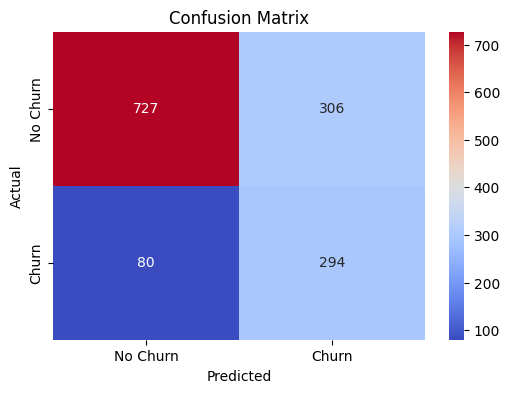

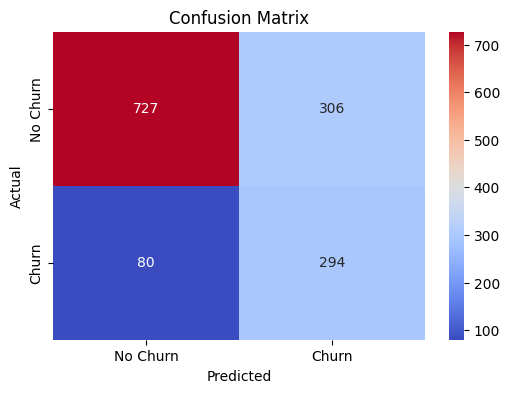

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(y_test, preds_best)
labels = ['No Churn', 'Churn']

# Plot it
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


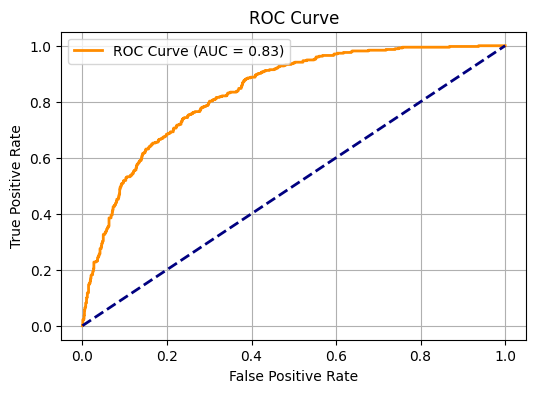

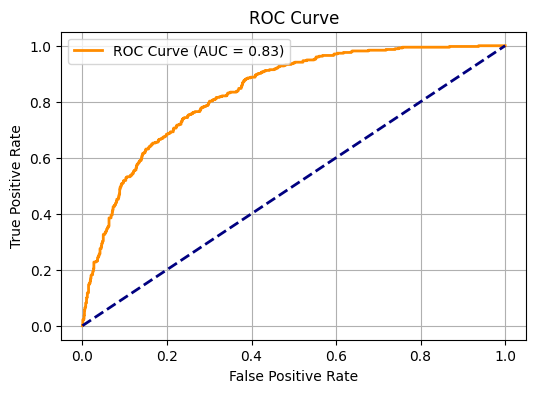

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get the probabilities (usually from predict_proba)
y_scores = best_lr.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

# Plot it
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--',color='navy', lw=2)  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


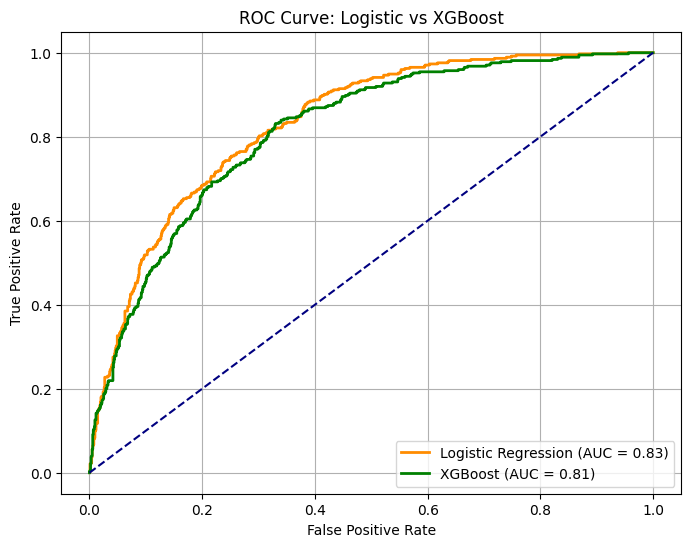

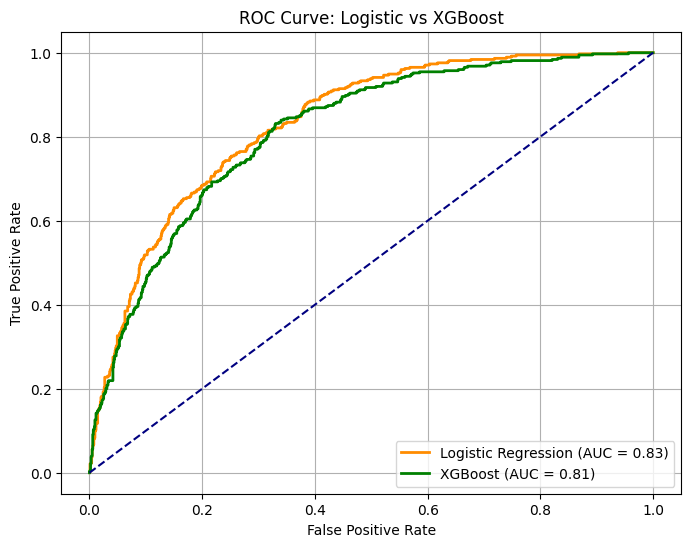

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Probabilities from each model
y_probs_lr = best_lr.predict_proba(X_test)[:,1]
y_probs_xgb = xgb.predict_proba(X_test)[:,1]

# Compute ROC curve and AUC for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_probs_lr)
auc_lr = auc(fpr_lr, tpr_lr)

# Compute ROC curve and AUC for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_probs_xgb)
auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot both curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})', color='darkorange', linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})', color='green', linewidth=2)

# Reference line for random chance
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

# Labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Logistic vs XGBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## Saving the data

In [18]:
import joblib

# Save the model
joblib.dump(best_lr, 'D:/Project/model/logistic_model.pkl')

X_test.to_csv("D:/Project/data/X_test.csv", index=False)
y_test.to_csv("D:/Project/data/y_test.csv", index=False)
X_train.to_csv("D:/Project/data/X_train.csv", index=False)
y_train.to_csv("D:/Project/data/y_train.csv", index=False)
